In [1]:
from darkspirals.disc import Disc
from darkspirals.substructure.realization import SubstructureRealization
from galpy.potential import MWPotential2014
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import astropy.units as apu
from copy import deepcopy
from darkspirals.orbit_util import sample_sag_orbit 
from darkspirals.orbit_util import integrate_single_orbit
from darkspirals.substructure.dsphr import PopulationdSphr
from darkspirals.distribution_function.compute_df import compute_df_from_orbits, compute_df_from_actions

plt.rcParams['axes.linewidth'] = 2.
plt.rcParams['xtick.major.width'] = 2.
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams.update({'font.size': 16})

try:
    from palettable.scientific.diverging import Vik_20 as cmap
    cmap = cmap.get_mpl_colormap()
except:
    print('could not find palettable; using a matplotlib cmap instead')
    cmap = plt.get_cmap('bwr')

A new version of galpy (1.10.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


### Make an instance of Disc, the main class in the package that stores the equilibrium actions, angles, frequencies, and orbits in an equilibrium potential

In [2]:
z_min_max = 1.5
vz_min_max = 100
phase_space_resolution = 80
z = np.linspace(-z_min_max,z_min_max,phase_space_resolution)
vz = np.linspace(-vz_min_max, vz_min_max, phase_space_resolution)
galactic_potential = MWPotential2014
time_Gyr = np.linspace(0.0, -1., 800) * apu.Gyr
disc = Disc(galactic_potential, galactic_potential, z_min_max, vz_min_max, phase_space_resolution, 
                time_Gyr, parallelize_action_angle_computation=True, compute_upfront=True)
print('DONE.')

DONE.


### Perform the calculation with one satellite 

realization contains: 1 dwarf galaxies


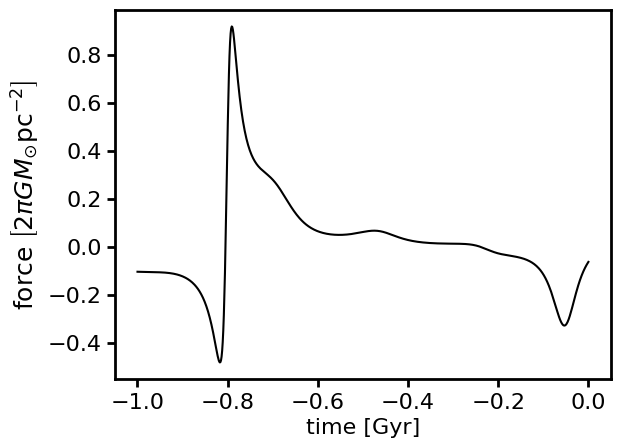

In [18]:
np.random.seed(10)
r_min = 25
# create a dummy class here
subhalo_abundance = 0.0
realization = SubstructureRealization.withDistanceCut(disc, norm=subhalo_abundance, 
                                                      r_min=r_min, 
                                                      num_halos_scale=1.0, 
                                                      m_low=10**6.7, 
                                                      m_high=10**8.0, 
                                                      t_max=-1.2)
# now add Sagittarius
realization.add_dwarf_galaxies(include_dwarf_list=['Sagittarius'],
                               log10_dsphr_masses={'Sagittarius': 9.})
print('realization contains: ' + str(len(realization.dwarf_galaxy_masses))+' dwarf galaxies')

# calculate the force exerted by the satellite on the solar position 
satellite = realization.orbits[0]
f = satellite.force_exerted(disc, physical_units=True)
plt.plot(time_Gyr, f, color='k')
ax = plt.gca()
ax.set_xlabel('time [Gyr]', fontsize=16)
ax.set_ylabel('force '+r'$\left[2 \pi G M_{\odot} \rm{pc^{-2}}\right]$', fontsize=18)
plt.show()

### Now calculate the force across the phase space exerted by the satellite and the change in the vertical action

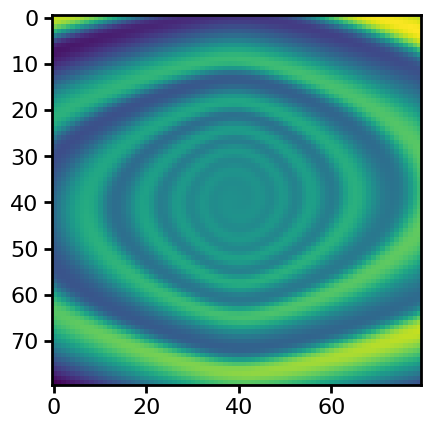

In [19]:
forces, _, _ = disc.compute_satellite_forces(realization.orbits, realization.potentials)
deltaJ_list = disc.compute_deltaJ_from_forces(forces)

plt.imshow(np.rot90(deltaJ_list[0])); plt.show()

### Compute the distribution function

In [20]:
# in equilibrium
deltaJ_eq = 0.0
vdis = 15.2 # velocity dispersion
df_eq = compute_df_from_actions(disc, 
                           vdis, 
                           deltaJ_net=deltaJ_eq,
                           df_model='LI&WIDROW') # no diffusion 
df_perturbed = compute_df_from_actions(disc, 
                           vdis, 
                           deltaJ_net=deltaJ_list,
                           df_model='LI&WIDROW') # no diffusion 

### Plot observables

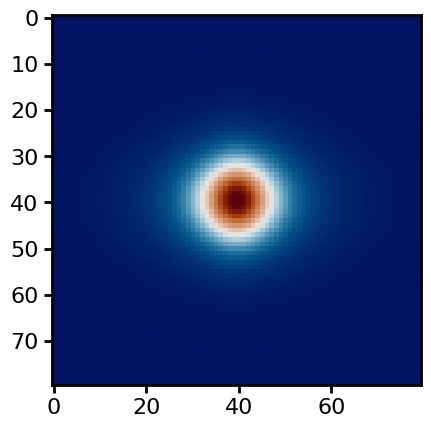

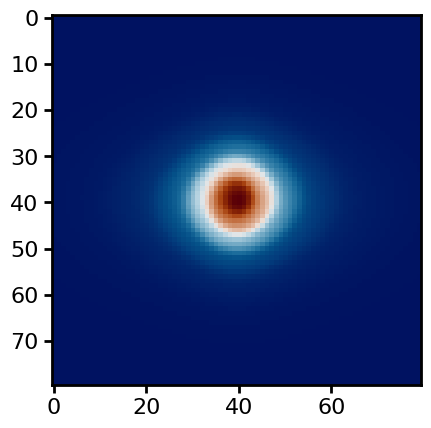

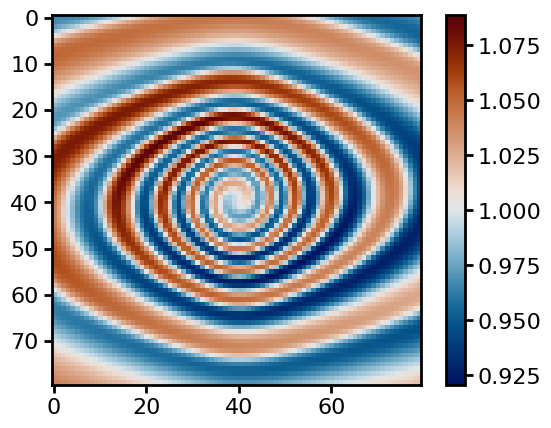

In [21]:
plt.imshow(np.rot90(df_eq.function), cmap=cmap); plt.show()
plt.imshow(np.rot90(df_perturbed.function), cmap=cmap); plt.show()
im=plt.imshow(np.rot90(df_perturbed.function/df_eq.function), cmap=cmap); 
plt.colorbar(im,cmap=cmap); plt.show()

### Diffusion 

First we can calculate the impact time as the time of maximum vertical force

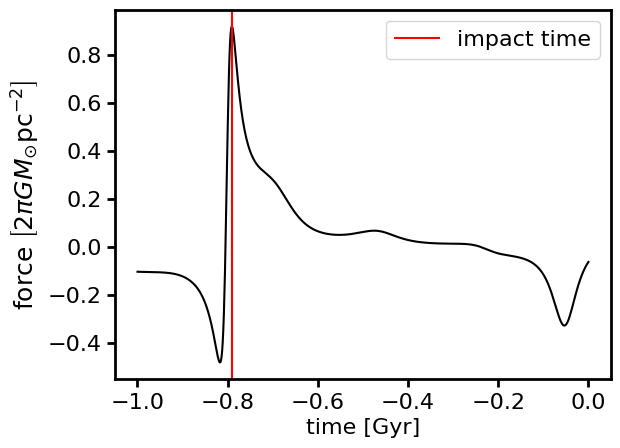

In [22]:
satellite = realization.orbits[0]
f = satellite.force_exerted(disc, physical_units=True)
impact_time = satellite.impact_time 
plt.plot(time_Gyr, f, color='k')
ax = plt.gca()
ax.axvline(-impact_time, color='r', label='impact time')
ax.set_xlabel('time [Gyr]', fontsize=16)
ax.set_ylabel('force '+r'$\left[2 \pi G M_{\odot} \rm{pc^{-2}}\right]$', fontsize=18)
plt.legend()
plt.show()

### Proceed as before, but now incorporate a model of diffusion by scattering against GMCs

We can use a function "compute_df_from_orbits" to streamline the whole calculation 

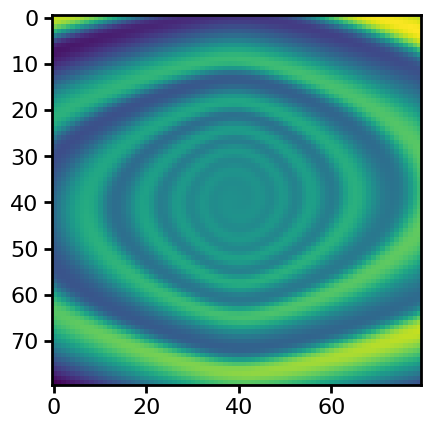

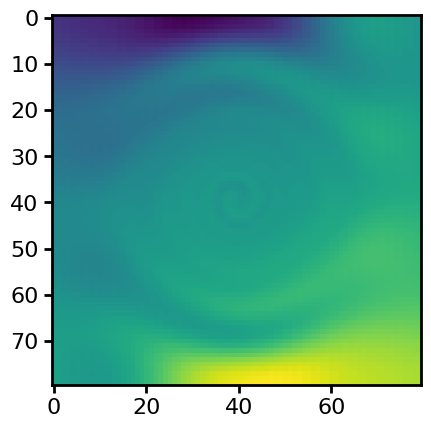

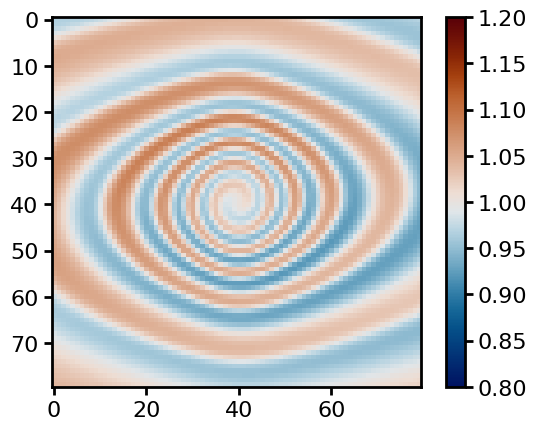

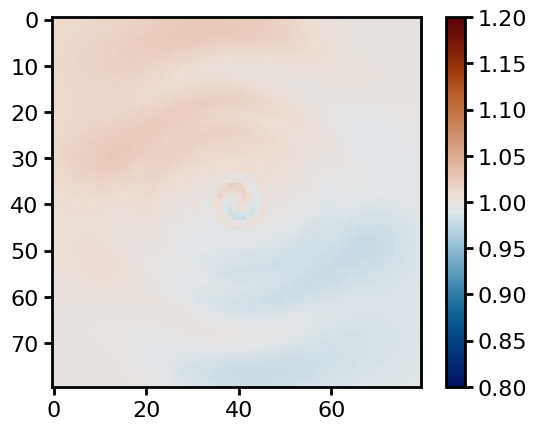

In [24]:
from darkspirals.diffusion import DiffusionConvolutionSpatiallyVarying

diffusion_model = DiffusionConvolutionSpatiallyVarying(disc)
df, deltaJ_with_diffusion = compute_df_from_orbits(disc,
                                                   vdis,
                                                   realization.orbits, 
                                                   realization.potentials, 
                                                   df_model='LI&WIDROW',
                                                   diffusion_model=diffusion_model)

plt.imshow(np.rot90(deltaJ_list[0])); plt.show()
plt.imshow(np.rot90(deltaJ_with_diffusion[0])); plt.show()

df_perturbed_with_diffusion = compute_df_from_actions(disc, 
                           vdis, 
                           deltaJ_net=deltaJ_with_diffusion,
                           df_model='LI&WIDROW') # no diffusion 

im=plt.imshow(np.rot90(df_perturbed.function/df_eq.function), cmap=cmap, vmin=0.8, vmax=1.2); 
plt.colorbar(im,cmap=cmap); plt.show()

im=plt.imshow(np.rot90(df_perturbed_with_diffusion.function/df_eq.function), cmap=cmap, vmin=0.8, vmax=1.2); 
plt.colorbar(im,cmap=cmap); plt.show()

### Calculation of other properties from the distribution function 

The distribution function classes (see darkspirals.distribution_function.base, darkspirals.distribution_function.df_models) have built-in methods for calculating observables 

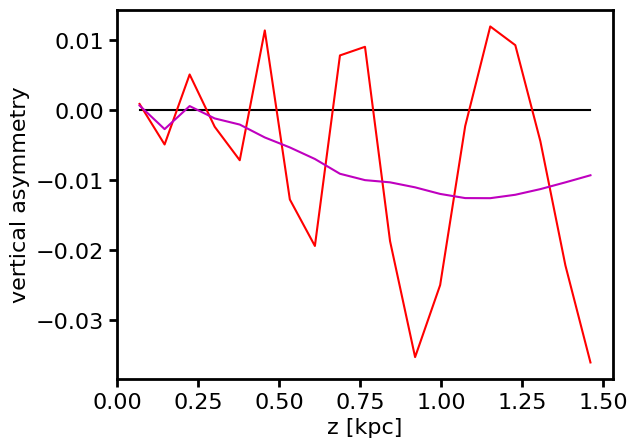

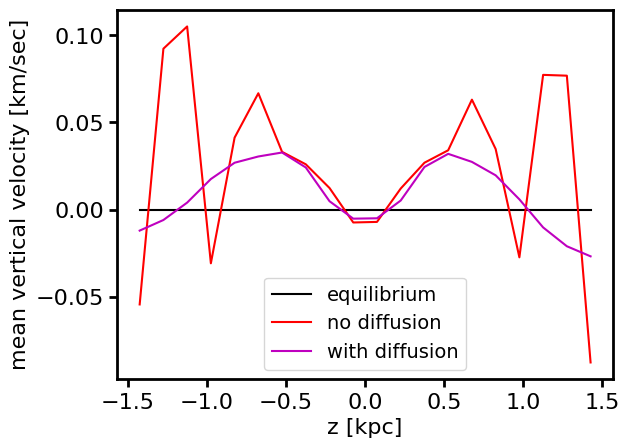

In [32]:
z_eval = np.linspace(0.03, 1.5, 20)
z, vertical_asymmetry = df_eq.vertical_asymmetry(z_eval)
plt.plot(z, vertical_asymmetry, color='k', label='equilibrium')

z, vertical_asymmetry = df_perturbed.vertical_asymmetry(z_eval)
plt.plot(z, vertical_asymmetry, color='r', label='no diffusion')

z, vertical_asymmetry = df_perturbed_with_diffusion.vertical_asymmetry(z_eval)
plt.plot(z, vertical_asymmetry, color='m', label='with diffusion')
plt.xlabel('z [kpc]', fontsize=16)
plt.ylabel('vertical asymmetry', fontsize=16)
plt.show()

z_eval = np.linspace(-1.5, 1.5, 21)
z, mvz = df_eq.mean_vertical_velocity(z_eval)
plt.plot(z, mvz, color='k', label='equilibrium')

z, mvz = df_perturbed.mean_vertical_velocity(z_eval)
plt.plot(z, mvz, color='r', label='no diffusion')

z, mvz = df_perturbed_with_diffusion.mean_vertical_velocity(z_eval)
plt.plot(z, mvz, color='m', label='with diffusion')

plt.xlabel('z [kpc]', fontsize=16)
plt.ylabel('mean vertical velocity [km/sec]', fontsize=16)
plt.legend(fontsize=14)
plt.show()

### Calculate actions/angles/frequncies before and after perturbation

We sample uniformly from the phase space in (z, vz), but assign weights to actions/angles/freq based on the distribution function 

In [28]:
# things won't change much for a small perturbation - to see a change in the actions/angles you should ramp up the mass of the satellite
n_samples = 10000
actions_eq, angles_eq, frequencies_eq, weights_eq = df_eq.sample_action_angle_freq(disc, n_samples)
actions, angles, frequencies, weights = df_perturbed.sample_action_angle_freq(disc, n_samples)

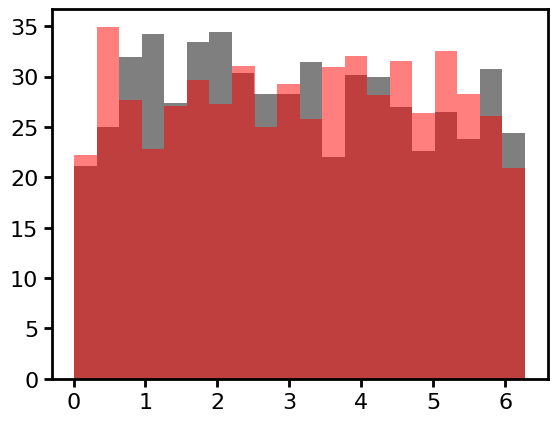

(array([ 4.67105249, 12.83009434, 16.88017291, 31.1602354 , 18.8181269 ,
        26.31178141, 32.86966858, 47.10973019, 45.12426644, 51.25873444,
        56.30972984, 51.95802521, 44.18241861, 36.61679528, 28.9686534 ,
        20.7950936 , 11.88748006,  5.16228232,  2.54713912,  0.79469401]),
 array([-4.  , -3.85, -3.7 , -3.55, -3.4 , -3.25, -3.1 , -2.95, -2.8 ,
        -2.65, -2.5 , -2.35, -2.2 , -2.05, -1.9 , -1.75, -1.6 , -1.45,
        -1.3 , -1.15, -1.  ]),
 <BarContainer object of 20 artists>)

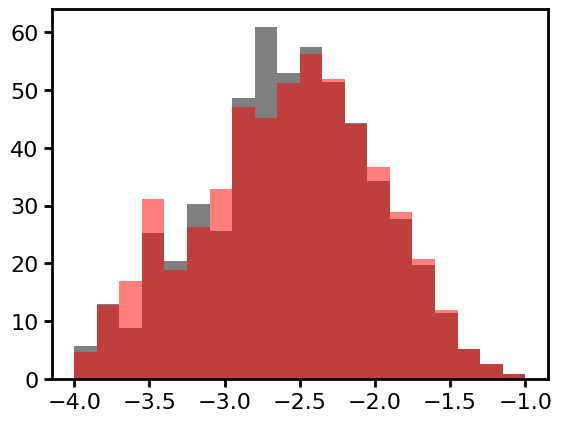

In [29]:
plt.hist(angles_eq, weights=weights_eq, bins=20, color='k',alpha=0.5)
plt.hist(angles, weights=weights, bins=20, color='r',alpha=0.5)
plt.show()

# everything is in galpy internal units here
plt.hist(np.log10(actions_eq), weights=weights_eq, bins=20,range=(-4, -1), color='k',alpha=0.5)
plt.hist(np.log10(actions), weights=weights, bins=20,range=(-4, -1), color='r',alpha=0.5)